In [76]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import qutip
import theano
import theano.tensor as T
from collections import OrderedDict
import itertools
from QubitNetwork import QubitNetwork
from qubit_network import load_network_from_file, sgd_optimization, transfer_J_values
import utils
from utils import chop, complex2bigreal, bigreal2complex
from results_analysis_utils import group_similar_elements, vanishing_elements

pairs = list(itertools.combinations(range(4), 2))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    interactions='all',
    self_interactions=('all', ['z']),
    system_qubits=[0, 1, 2]
#     J=new_Jvalues
)
net = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=200,
    batch_size=10,
    target_gate=qutip.toffoli(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01,
    saveafter_file='nets/test.pickle'
)

AttributeError: module 'qutip' has no attribute 'toffolib'

Let us see how the constructed gate actually implements the toffoli.
More specifically, the optimization only assures that we are getting a gate of the form
$$ \mathcal U = \tilde{\mathcal U} \otimes P_A + (...)$$
where $P_A$ is the projector over the ancilla state that was used for the training.
This means that in the case under consideration we should have
$$ \mathcal U = \mathcal U_{toffoli} \otimes \begin{pmatrix}1&0\\0&0\end{pmatrix} + (...).$$
As shown below, this seems to be indeed the case:

In [93]:
net = QubitNetwork.load_network_from_file('nets/toffoli.pickle')
gate = qutip.Qobj(net.get_current_gate(), dims=[[2, 2, 2, 2]] * 2)

p00 = qutip.ket2dm(qutip.basis(2, 0))
p11 = qutip.ket2dm(qutip.basis(2, 1))
p01 = qutip.Qobj([[0, 1], [0, 0]])
p10 = qutip.Qobj([[0, 0], [1, 0]])

i3 = qutip.tensor([qutip.qeye(2) for _ in range(3)])
ntlp = utils.normalize_topleft_phase

extracted1 = (qutip.tensor(i3, p00) * gate * qutip.tensor(i3, p00)).ptrace([0, 1, 2])
extracted2 = (qutip.tensor(i3, p11) * gate * qutip.tensor(i3, p11)).ptrace([0, 1, 2])
extracted3 = (qutip.tensor(i3, p01) * gate * qutip.tensor(i3, p01)).ptrace([0, 1, 2])
extracted4 = (qutip.tensor(i3, p10) * gate * qutip.tensor(i3, p10)).ptrace([0, 1, 2])

display(chop(ntlp(chop(extracted1))))
display(ntlp(chop(extracted2)))
display(ntlp(chop(extracted3)))
display(ntlp(chop(extracted4)))

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]]

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[  5.83951148e-01+0.j           1.62434082e-01-0.58318838j
   -3.07493013e-01-0.14184159j  -1.09834616e-01+0.38909997j
    6.55944180e-02-0.04760238j   4.27745341e-03+0.01784894j
    5.83608871e-02+0.04454531j   1.93010523e-02-0.04130145j]
 [  1.62437461e-01-0.58319103j   5.31745528e-01+0.27921003j
   -2.16308406e-01+0.34791808j  -2.72841947e-01-0.15085488j
   -1.41142187e-02-0.01473078j  -1.83223806e-02+0.01353968j
   -5.68142758e-02-0.04111847j   7.74963606e-03+0.04290244j]
 [ -4.62114482e-02+0.18397513j   4.58262614e-01+0.16343632j
   -1.08457710e-01+0.1673485j    7.46808372e-01+0.280339j
   -1.00059273e-01-0.1047949j   -4.23474798e-04+0.00411472j
    1.27962085e-01+0.10846802j  -3.67550730e-02-0.02681088j]
 [  4.78207181e-01+0.10814268j  -6.63162531e-02+0.14325996j
    6.68834189e-01+0.41803916j  -1.84049724e-02+0.22339884j
    6.42882289e-03+0.05188583j   3.40797257e-03+0.059132

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

In [94]:
net.save_gate_to_file('matrices/toffoli_4q1a_all_all.csv')

In [44]:
Jvalues = net.J.get_value()
display(Jvalues)
# [net.J_index_to_interaction(v) for v in np.where(np.abs(Jvalues) < 1e-3)[0]]
# net.active_hs

array([  1.87000602e+00,   2.16314398e+00,  -6.34280758e-01,
        -1.43185669e+00,  -2.26583486e-01,   1.48457146e-01,
        -5.51012222e-02,  -1.48582117e-01,  -2.26554949e-01,
        -9.29009023e-02,  -2.29440692e+00,   3.93267029e-01,
         1.20565591e+00,  -9.20444695e-02,  -1.70732662e-01,
         3.28081756e-01,   6.44053652e-02,  -3.28134102e-01,
        -1.70706718e-01,   1.72991276e+00,  -2.86816694e-01,
         1.85684167e+00,   8.52963605e-06,   4.84895298e-07,
        -1.47158031e-01,  -4.74586988e-07,   8.57338836e-06,
        -2.84515193e-02,   3.79143042e-07,   2.59604261e-07,
         8.89976429e-01,   2.22197952e+00,   9.64549375e-01,
        -4.71647831e-01,  -1.85413750e+00,   4.71650147e-01,
         9.64541125e-01,  -3.86453088e+00,  -2.03959615e-01,
        -7.87375400e-01,   6.29098329e-07,  -7.93233727e-07,
        -7.24257751e-02,  -4.52798637e-07,  -6.93876287e-08,
        -1.46086927e+00,   1.12940873e-06,   6.74970597e-08,
        -8.14000200e-01,

Vanishing interactions:

In [54]:
vanishing_indices = np.where(np.abs(Jvalues) < 1e-5)[0]
[net.J_index_to_interaction(v) for v in vanishing_indices]

[((0, 3), 'xx'),
 ((0, 3), 'xy'),
 ((0, 3), 'yx'),
 ((0, 3), 'yy'),
 ((0, 3), 'zx'),
 ((0, 3), 'zy'),
 ((1, 3), 'xx'),
 ((1, 3), 'xy'),
 ((1, 3), 'yx'),
 ((1, 3), 'yy'),
 ((1, 3), 'zx'),
 ((1, 3), 'zy'),
 ((2, 3), 'xx'),
 ((2, 3), 'xy'),
 ((2, 3), 'yx'),
 ((2, 3), 'yy'),
 ((2, 3), 'zx'),
 ((2, 3), 'zy')]

In [46]:
groups = utils.group_similar_elements(Jvalues)
groups = [g for g in groups if len(g) > 1]


[[net.J_index_to_interaction(i) for i in groups[j]] for j in range(len(groups))]

[[((0, 1), 'xx'), ((0, 1), 'yy')],
 [((0, 1), 'yz'), ((0, 2), 'xx')],
 [((0, 2), 'xy'), ((0, 2), 'yz')],
 [((0, 3), 'xx'),
  ((0, 3), 'xy'),
  ((0, 3), 'yx'),
  ((0, 3), 'yy'),
  ((0, 3), 'zx'),
  ((0, 3), 'zy'),
  ((1, 3), 'xx'),
  ((1, 3), 'xy'),
  ((1, 3), 'yx'),
  ((1, 3), 'yy'),
  ((1, 3), 'zx'),
  ((1, 3), 'zy'),
  ((2, 3), 'xx'),
  ((2, 3), 'xy'),
  ((2, 3), 'yx'),
  ((2, 3), 'yy'),
  ((2, 3), 'zx'),
  ((2, 3), 'zy')],
 [((1, 2), 'xy'), ((1, 2), 'yz')]]

OrderedDict([((0, 1), ['zz']), ((0, 2), ['zz']), ((1, 2), ['zz']), ((0, 3), ['xx']), ((1, 3), ['zz']), ((2, 3), ['zz'])])
Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


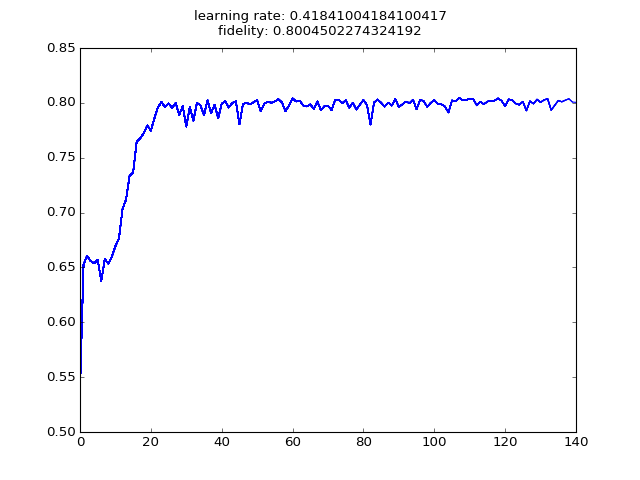

Finished training


In [67]:
interactions = OrderedDict([((0, 1), 'zz'),
                            ((0, 2), 'zz'),
                            ((1, 2), 'zz'),
                            ((0, 3), 'xx'),
                            ((1, 3), 'zz'),
                            ((2, 3), 'zz')])
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    interactions=interactions,
    self_interactions=('all', ['x', 'z']),
    system_qubits=3
)
net = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=10,
    target_gate=qutip.toffoli(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
#     saveafter_file='nets/fredkin_best.pickle'
)

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


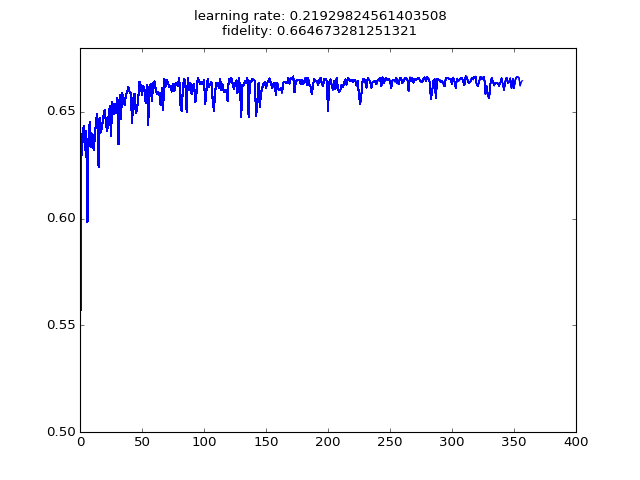

Finished training


In [74]:
interactions = OrderedDict([((0, 1), 'zz'),
                            ((0, 2), 'zz'),
                            ((1, 2), 'zz'),
                            ((0, 3), 'xx'),
                            ((1, 3), 'zz'),
                            ((2, 3), 'zz')])
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=interactions,
    self_interactions=('all', ['x', 'z']),
    ancillae_state=qutip.Qobj([[1], [1]]).unit()
)
net = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=10,
    target_gate=qutip.toffoli(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


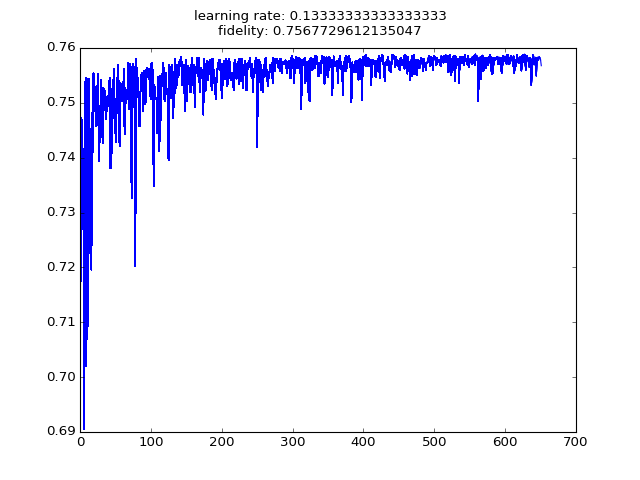

Finished training


In [78]:
interactions = OrderedDict([((0, 1), 'zz'),
                            ((0, 2), 'zz'),
                            ((1, 2), 'zz'),
                            ((0, 3), 'xx'),
                            ((1, 3), 'zz'),
                            ((2, 3), 'zz')])
eta = 0.8182
xi = 0.0587
initial_ancilla = qutip.Qobj([[np.cos(eta)], [np.sin(eta)]])
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=interactions,
    self_interactions=('all', ['x', 'z']),
    ancillae_state=initial_ancilla
)
net = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=10,
    target_gate=qutip.toffoli(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


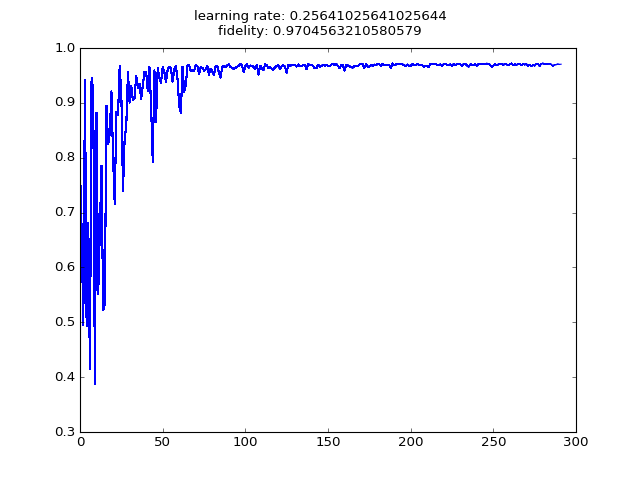

Finished training


In [91]:
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=('all', ['xx', 'yy', 'zz', 'xz', 'z']),
    ancillae_state=qutip.basis(2, 0)
)
net = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=2,
    target_gate=qutip.toffoli(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


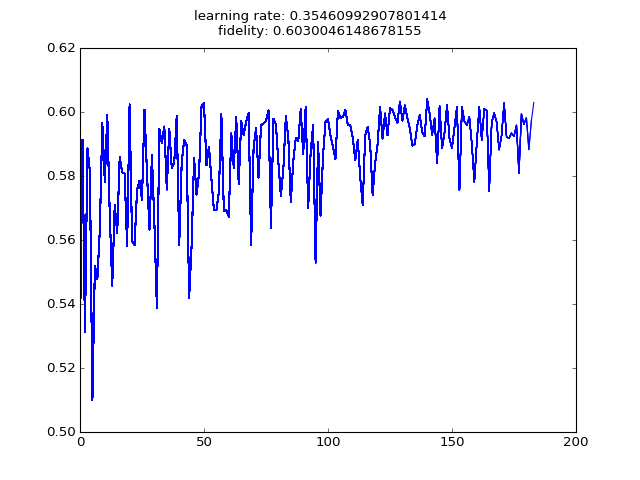

Finished training


In [90]:
interactions = OrderedDict([((0, 1), 'zz'), ((0, 2), 'zz'), ((0, 3), 'zz'),
                            ((1, 2), 'zz'), ((1, 3), 'zz'), ((2, 3), 'zz'),
                            ((0, 1), 'xz'), ((0, 2), 'xz'), ((0, 3), 'xz'),
                            ((1, 2), 'xz'), ((1, 3), 'xz'), ((2, 3), 'xz'),
                            ((0, 1), 'xx'), ((0, 2), 'xx'), ((1, 2), 'zz'),
                            ((0, 1), 'yy'), ((0, 2), 'yy'), ((1, 2), 'yy')])
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=interactions,
    self_interactions=('all', ['z']),
    ancillae_state=qutip.basis(2, 0)
)
net = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=2,
    target_gate=qutip.toffoli(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

True
Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


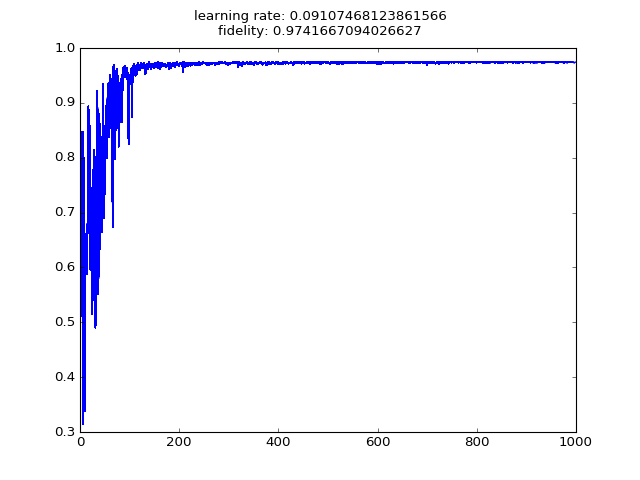

Finished training


In [2]:
interactions = [((0, 1), 'zz'), ((0, 2), 'zz'), ((0, 3), 'zz'),
                ((1, 2), 'zz'), ((1, 3), 'zz'), ((2, 3), 'zz'),
                ((0, 1), 'xz'), ((0, 2), 'xz'), ((0, 3), 'xz'),
                ((1, 2), 'xz'), ((1, 3), 'xz'), ((2, 3), 'xz'),
                ((0, 1), 'xx'), ((0, 2), 'xx'), ((1, 2), 'zz'),
                ((0, 1), 'yy'), ((0, 2), 'yy'), ((1, 2), 'yy'),
                (0, 'z'), (1, 'z'), (2, 'z'), (3, 'z')]
net = QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=interactions,
    ancillae_state=qutip.basis(2, 0)
)

net = sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=2,
    target_gate=qutip.toffoli(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


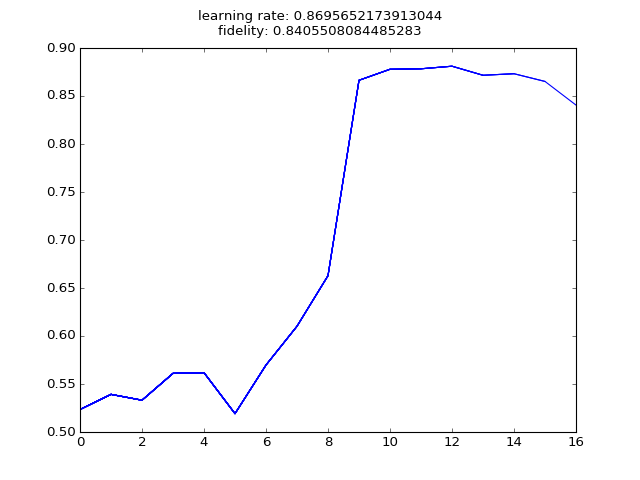

Finished training
Final fidelity: 0.7332951872566236


In [29]:
interactions = [((0, 1), 'zz'), ((0, 2), 'zz'), ((0, 3), 'zz'),
                ((1, 2), 'zz'), ((1, 3), 'zz'), ((2, 3), 'zz'),
                ((0, 1), 'xx'), ((0, 2), 'xx'), ((0, 3), 'xx'),
                ((1, 2), 'xx'), ((1, 3), 'xx'), ((2, 3), 'xx'),
                (0, 'z'), (1, 'z'), (2, 'z'), (3, 'z'),
                (0, 'x'), (1, 'x'), (2, 'x'), (3, 'x')]
net = QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=interactions,
    ancillae_state=qutip.basis(2, 0)
)

net = sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=2,
    target_gate=qutip.toffoli(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

In [30]:
print(net.test_fidelity())

0.7307879373291074


In [31]:
net.J.get_value()
# net.interactions
# net.test_fidelity()

array([ -1.47624944e+00,  -1.68671173e-03,   1.32064280e+00,
        -1.06915679e-01,   3.29860927e-01,  -9.53446131e-02,
         2.07471937e-02,  -2.61694983e+00,   1.58589806e+00,
         5.72621561e-02,  -4.86076861e-02,  -5.34661631e-02,
        -1.95254242e-01,   2.91316223e+00,   9.95461687e-02,
         6.09872104e-01,  -9.83200277e-01,   3.13767932e-02,
         2.30830666e-01,   1.46913730e+00])

In [34]:
net.J_index_to_interaction(8)
net2.tuple_to_J_index(net.J_index_to_interaction(2))

2

In [35]:
net2 = QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=interactions,
    ancillae_state=qutip.basis(2, 0)
)
transfer_J_values(net, net2)
net2.J.get_value()

Setting new J values: 
[ -1.47624944e+00  -1.68671173e-03   1.32064280e+00  -1.06915679e-01
   3.29860927e-01  -9.53446131e-02   2.07471937e-02  -2.61694983e+00
   1.58589806e+00   5.72621561e-02  -4.86076861e-02  -5.34661631e-02
  -1.95254242e-01   2.91316223e+00   9.95461687e-02   6.09872104e-01
  -9.83200277e-01   3.13767932e-02   2.30830666e-01   1.46913730e+00]


array([ -1.47624944e+00,  -1.68671173e-03,   1.32064280e+00,
        -1.06915679e-01,   3.29860927e-01,  -9.53446131e-02,
         2.07471937e-02,  -2.61694983e+00,   1.58589806e+00,
         5.72621561e-02,  -4.86076861e-02,  -5.34661631e-02,
        -1.95254242e-01,   2.91316223e+00,   9.95461687e-02,
         6.09872104e-01,  -9.83200277e-01,   3.13767932e-02,
         2.30830666e-01,   1.46913730e+00])

Setting new J values: 
[ -1.47624944e+00  -1.68671173e-03   1.32064280e+00  -1.06915679e-01
   3.29860927e-01  -9.53446131e-02   2.07471937e-02  -2.61694983e+00
   1.58589806e+00   5.72621561e-02  -4.86076861e-02  -5.34661631e-02
  -1.95254242e-01   2.91316223e+00   9.95461687e-02   6.09872104e-01
  -9.83200277e-01   3.13767932e-02   2.30830666e-01   1.46913730e+00]
Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


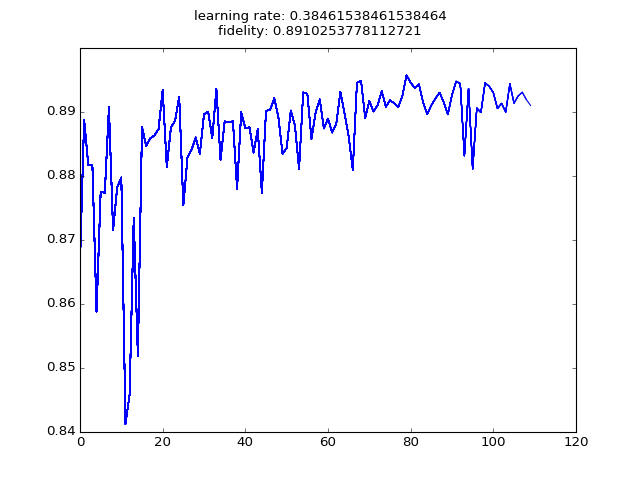

Finished training
Final fidelity: 0.9085234391014421


In [36]:
net2 = QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=interactions,
    ancillae_state=qutip.basis(2, 0)
)
transfer_J_values(net, net2)
sgd_optimization(
    net=net2,
    learning_rate=.8,
    n_epochs=1000,
    batch_size=2,
    target_gate=qutip.toffoli(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

In [38]:
net2.J.get_value()

array([-1.43487411,  0.02681721,  1.3901569 , -0.06569728,  0.59210432,
       -0.02211829,  0.05041513, -2.83353115,  1.64447064,  0.08632803,
       -0.07130228, -0.08232956, -0.10494311,  3.12232157,  0.03064352,
        0.75516234, -1.03839913,  0.00365764,  0.36664539,  1.55170872])

### Test with values provided in *Banchi et al.*:

In [69]:
eta = 0.8182
xi = 0.0587
initial_ancilla = qutip.Qobj([[np.cos(eta)], [np.sin(eta) * np.exp(1j * xi)]])
# display(initial_ancilla)
net_paper = QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=('all', ['zz', 'xx', 'z', 'x']),
    ancillae_state=initial_ancilla,
    target_gate=qutip.toffoli()
)
net_paper.J.set_value(np.zeros_like(net_paper.J.get_value()))

Jvalues = net_paper.J.get_value()

J01zz = -8.940
J02zz = -4.957
J03zz = -5.657
J12zz = J02zz
J13zz = J03zz
h0z = -2.428
h1z = h0z
h2z = J02zz
h3z = -0.165
h2x = -19.08
h3x = -4.267
J23xx = 15.06

Jvalues[net.tuple_to_J_index(((0, 1), 'zz'))] = J01zz / 4
Jvalues[net.tuple_to_J_index(((0, 2), 'zz'))] = J02zz / 4
Jvalues[net.tuple_to_J_index(((0, 3), 'zz'))] = J03zz / 4
Jvalues[net.tuple_to_J_index(((1, 2), 'zz'))] = J12zz / 4
Jvalues[net.tuple_to_J_index(((1, 3), 'zz'))] = J13zz / 4
Jvalues[net.tuple_to_J_index(((2, 3), 'xx'))] = J23xx / 4
Jvalues[net.tuple_to_J_index((0, 'z'))] = h0z / 2
Jvalues[net.tuple_to_J_index((1, 'z'))] = h1z / 2
Jvalues[net.tuple_to_J_index((2, 'z'))] = h2z / 2
Jvalues[net.tuple_to_J_index((3, 'z'))] = h3z / 2
Jvalues[net.tuple_to_J_index((2, 'x'))] = h2x / 2
Jvalues[net.tuple_to_J_index((3, 'x'))] = h3x / 2

net_paper.J.set_value(Jvalues)

# net.test_fidelity(n_samples=1000)
qutip.Qobj(net_paper.get_current_gate())

Quantum object: dims = [[16], [16]], shape = (16, 16), type = oper, isherm = False
Qobj data =
[[  9.85993068e-01-0.13073745j   3.06232678e-03-0.02804875j
   -2.61308157e-03-0.06245135j  -2.60867186e-04+0.07760291j
    0.00000000e+00+0.j           0.00000000e+00+0.j           0.00000000e+00+0.j
    0.00000000e+00+0.j           0.00000000e+00+0.j           0.00000000e+00+0.j
    0.00000000e+00+0.j           0.00000000e+00+0.j           0.00000000e+00+0.j
    0.00000000e+00+0.j           0.00000000e+00+0.j           0.00000000e+00+0.j        ]
 [  3.06232678e-03-0.02804875j   9.93961557e-01-0.0213174j
   -1.10557593e-03+0.06207957j   4.49744094e-03-0.08315383j
    0.00000000e+00+0.j           0.00000000e+00+0.j           0.00000000e+00+0.j
    0.00000000e+00+0.j           0.00000000e+00+0.j           0.00000000e+00+0.j
    0.00000000e+00+0.j           0.00000000e+00+0.j           0.00000000e+00+0.j
    0.00000000e+00+0.j           0.00000000e+00+0.j           0.00000000e+00+0.j        ]


Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


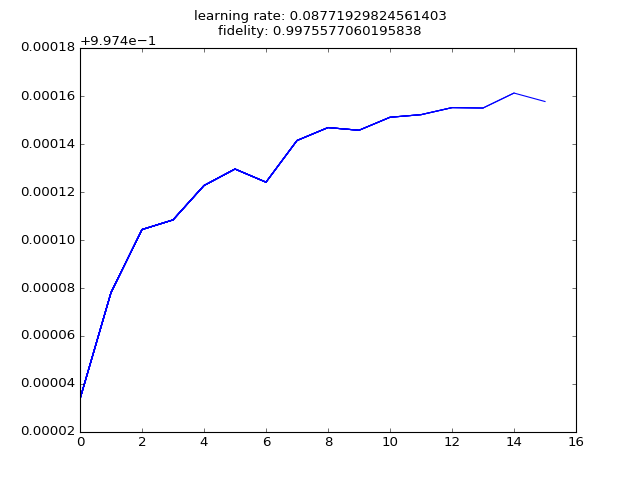

Finished training
Final fidelity: 0.9975362939367018


In [73]:
eta = 0.8182
xi = 0.0587
initial_ancilla = qutip.Qobj([[np.cos(eta)], [np.sin(eta) * np.exp(1j * xi)]])
# display(initial_ancilla)
net = QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=('all', ['zz', 'xx', 'z', 'x']),
    ancillae_state=initial_ancilla,
    target_gate=qutip.toffoli()
)
transfer_J_values(net_paper, net)
# print(isinstance(net, QubitNetwork))
sgd_optimization(
    net=net,
    learning_rate=.1,
    n_epochs=1000,
    batch_size=2,
    target_gate=qutip.toffoli(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


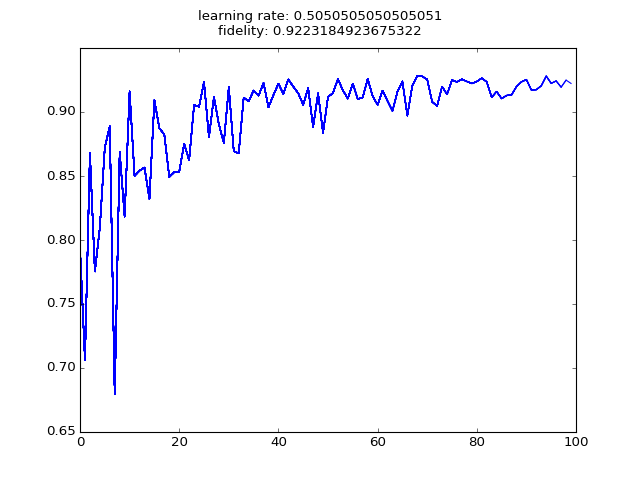

In [ ]:
eta = 0.8182
xi = 0.0587
initial_ancilla = qutip.Qobj([[np.cos(eta)], [np.sin(eta) * np.exp(1j * xi)]])

# set up a set of interaction mimicking those of Banchi et al.
interactions = []
for pair in pairs:
    if pair != (2, 3):
        interactions.append((pair, 'zz'))
interactions.append(((2, 3), 'xx'))
for qb in range(4):
    interactions.append((qb, 'z'))
    interactions.append((qb, 'x'))

# define the network
net = QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=interactions,
    ancillae_state=initial_ancilla,
    target_gate=qutip.toffoli()
)
net.J.set_value(np.ones_like(net.J.get_value()))

# train the network
sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=2,
    target_gate=qutip.toffoli(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)